### Parse `Google Scanned Objects`

In [1]:
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
sys.path.append('../../package/mujoco_helper/') # for 'mujoco_parser'
sys.path.append('../../package/kinematics_helper/') # for 'transforms'
sys.path.append('../../package/utility/') # for 'utils'
from mujoco_parser import *
from transforms import *
from utils import *
from ik import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:",MUJOCO_VERSION)

MuJoCo version: (3, 1, 6)


In [2]:
# Get (Google's) scanned object names
folder_path = './converted_models'
scanned_object_names = [f.name for f in os.scandir(folder_path) if f.is_dir()]
print ("scanned_object_names:[%d]"%(len(scanned_object_names)))

# Sample object names
n_loaded_object = 10
# loaded_objects = random.sample(scanned_object_names,n_loaded_object) # sample
loaded_objects = ['Just_For_Men_ShampooIn_Haircolor_Light_Brown_25', 'Avengers_Thor_PLlrpYniaeB', 'Womens_Bluefish_2Eye_Boat_Shoe_in_Brown_Deerskin_i1TgjjO0AKY', '45oz_RAMEKIN_ASST_DEEP_COLORS', 'Ecoforms_Plant_Container_GP16AMOCHA', 'Cole_Hardware_Dishtowel_Multicolors', 'CREATIVE_BLOCKS_35_MM', 'Reebok_SH_PRIME_COURT_MID', 'Ecoforms_Plant_Saucer_SQ1HARVEST', 'Ecoforms_Cup_B4_SAN']
print ("n_loaded_object:[%d]"%(n_loaded_object))
print ("loaded_objects:%s"%(loaded_objects))

# Append sampled object names to xml
xml_path = './scene_table.xml'
tree = ET.parse(xml_path)
root = tree.getroot()
for obj_name in loaded_objects:
    file_path = '%s/%s/model.xml'%(folder_path,obj_name)
    include_tag = ET.Element('include',attrib={'file':file_path})
    root.append(include_tag)
xml_string = prettify(root) # indent xml

# Print xml string
print ("\n\n",xml_string,"\n\n")

# Parse 'xml_string'
env = MuJoCoParserClass(name='Tabletop',xml_string=xml_string,verbose=True)

scanned_object_names:[1030]
n_loaded_object:[10]
loaded_objects:['Just_For_Men_ShampooIn_Haircolor_Light_Brown_25', 'Avengers_Thor_PLlrpYniaeB', 'Womens_Bluefish_2Eye_Boat_Shoe_in_Brown_Deerskin_i1TgjjO0AKY', '45oz_RAMEKIN_ASST_DEEP_COLORS', 'Ecoforms_Plant_Container_GP16AMOCHA', 'Cole_Hardware_Dishtowel_Multicolors', 'CREATIVE_BLOCKS_35_MM', 'Reebok_SH_PRIME_COURT_MID', 'Ecoforms_Plant_Saucer_SQ1HARVEST', 'Ecoforms_Cup_B4_SAN']


 <?xml version="1.0" ?>
<mujoco model="Scanned Objects">
    <size memory="500M"/>
    <compiler angle="radian" autolimits="true"/>
    <option integrator="RK4" noslip_iterations="20"/>
    <default>
        <joint armature="0.1" damping="0.1"/>
        <default class="visual_only">
            <geom type="mesh" contype="0" conaffinity="0" group="2"/>
        </default>
        <default class="no_visual_collision">
            <geom type="capsule" solimp=".9 .99 .001" solref=".015 1" group="3"/>
        </default>
        <default class="visual_collision">
  

In [3]:
env.reset()
env.init_viewer(
    black_sky   = True,
    transparent = False,
    geomgroup_0     = 1, # floor sky
    geomgroup_1     = 1, # collision
    geomgroup_2     = 1, # visual (this slows down)
)
obj_names = env.get_body_names(prefix='body_obj_')
obj_xyzs = sample_xyzs(
    n_sample=len(obj_names),
    x_range=[-0.2,+1.4],y_range=[-0.5,+0.5],z_range=[0.8,0.8],
    min_dist=0.25, # 0.25
)
obj_Rs = np.empty((0,9))
for obj_idx,obj_body_name in enumerate(obj_names):
    env.set_p_base_body(body_name=obj_body_name,p=obj_xyzs[obj_idx,:])
    R_rand = rpy2r(np.deg2rad([0,0,360*np.random.rand()]))
    obj_Rs = np.vstack((obj_Rs,R_rand.flatten()))
    env.set_R_base_body(body_name=obj_body_name,R=R_rand)
env.forward(increase_tick=False)
while env.is_viewer_alive():
    env.step()
    if env.loop_every(tick_every=10):
        env.plot_T()
        env.plot_time()
        # env.plot_contact_info(rate=1.0)
        # env.plot_bodies_T(body_names=obj_body_names,plot_axis=False,axis_len=0.1,axis_width=0.005,plot_name=True)
        env.render()
print ("Done.")

2024-12-15 17:58:26.996 python[10153:472313] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-15 17:58:26.996 python[10153:472313] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Done.


### Capture Point Cloud of Whole Scene

In [4]:
env.reset()
env.init_viewer(
    azimuth           = 163.88,
    distance          = 4.5,
    elevation         = -10,
    lookat            = [0.01,0.11,0.5],
    transparent       = False,
    black_sky         = True,
    use_rgb_overlay   = True,
    loc_rgb_overlay   = 'top right',
    use_rgb_overlay_2 = False,
    loc_rgb_overlay_2 = 'bottom right',
)

for obj_idx,obj_body_name in enumerate(obj_names):
    env.set_p_base_body(body_name=obj_body_name,p=obj_xyzs[obj_idx,:])
    obj_R = obj_Rs[obj_idx,:].reshape(3,3)
    env.set_R_base_body(body_name=obj_body_name,R=obj_R)
env.forward(increase_tick=False)

p_center = np.array([0.6, 0, 1.8])
radius = 1.5
whole_pcd_array = np.empty((0,3))

R_start = rpy2r(np.radians([0,-45,0]))

env.forward(increase_tick=True)

while env.is_viewer_alive() and env.tick < 2*np.pi*100:
    env.step()

    theta = env.tick / 100
    p_curr = p_center - radius* np.array((np.cos(theta),np.sin(theta),0))
    R_spin = rpy2r([0,0,theta])
    R_curr = np.dot(R_spin,R_start)
    env.data.cam('external').xpos = p_curr
    env.data.cam('external').xmat = np.reshape(R_curr,(9,))

    if env.loop_every(tick_every=10):
        rgb_ext,depth_ext,pcd_ext,T_cam_ext = env.get_fixed_cam_rgbd_pcd(
            cam_name='external',downscale_pcd=0.1)
        pcd_ext_above = pcd_ext[pcd_ext[:,2] > 0.8]
        whole_pcd_array = np.vstack((whole_pcd_array,pcd_ext_above))
        
    if env.loop_every(tick_every=10):
        env.plot_T(T=T_cam_ext,axis_len=0.1,axis_width=0.005,label='External')
        env.viewer.add_rgb_overlay(rgb_img_raw=rgb_ext)
        for p in pcd_ext_above: env.plot_sphere(p=p,r=0.002,rgba=[0.05,0.95,0.05,1])
        env.render()

env.close_viewer()

In [5]:
from sklearn.cluster import DBSCAN

def cluster_point_cloud(points, eps=0.1, min_samples=10):
    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(points)
    
    # Get number of clusters (excluding noise points labeled as -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Organize points by cluster
    clustered_points = {}
    for i in range(n_clusters):
        cluster_mask = (labels == i)
        clustered_points[i] = points[cluster_mask]
    
    return labels, n_clusters, clustered_points

labels, n_clusters, clustered_points = cluster_point_cloud(whole_pcd_array, eps=0.05, min_samples=10)

In [6]:
def generate_distinct_colors(n):
    def hsv_to_rgb(h, s, v):
        """Convert HSV color values to RGB."""
        h_i = int(h * 6)
        f = h * 6 - h_i
        p = v * (1 - s)
        q = v * (1 - f * s)
        t = v * (1 - (1 - f) * s)
        
        if h_i == 0:
            return v, t, p
        elif h_i == 1:
            return q, v, p
        elif h_i == 2:
            return p, v, t
        elif h_i == 3:
            return p, q, v
        elif h_i == 4:
            return t, p, v
        else:
            return v, p, q
    
    colors = []
    for i in range(n):
        # Use golden ratio to spread hues evenly
        hue = (i * 0.618033988749895) % 1.0
        
        # Keep saturation and value high for distinct colors
        saturation = 0.8 + np.random.random() * 0.2  # 0.8-1.0
        value = 0.8 + np.random.random() * 0.2       # 0.8-1.0
        
        # Convert HSV to RGB
        r, g, b = hsv_to_rgb(hue, saturation, value)
        
        # Add alpha value of 1
        colors.append((r, g, b, 1.0))
    
    return colors

colors = generate_distinct_colors(n_clusters)

In [7]:
env.reset()
env.init_viewer(
    azimuth           = 163.88,
    distance          = 4.5,
    elevation         = -10,
    lookat            = [0.01,0.11,0.5],
    transparent       = False,
    black_sky         = True,
)

for obj_idx,obj_body_name in enumerate(obj_names):
    env.set_p_base_body(body_name=obj_body_name,p=obj_xyzs[obj_idx,:])
    obj_R = obj_Rs[obj_idx,:].reshape(3,3)
    env.set_R_base_body(body_name=obj_body_name,R=obj_R)
env.forward(increase_tick=False)

while env.is_viewer_alive():
    env.step()

    env.plot_T(T=T_cam_ext,axis_len=0.1,axis_width=0.005,label='External')
    for i in range(n_clusters):
        for p in clustered_points[i][::10]: env.plot_sphere(p=p,r=0.002,rgba=colors[i])
    env.render()

env.close_viewer()

### Capture Point Cloud of Target Object

In [8]:
# Target object name
# target_object = loaded_objects[random.randint(0,len(loaded_objects)-1)]
target_object = 'Ecoforms_Plant_Container_GP16AMOCHA'
print ("target_object:",target_object)

# Append sampled object names to xml
xml_path = './scene_table.xml'
tree = ET.parse(xml_path)
root = tree.getroot()
file_path = '%s/%s/model.xml'%(folder_path,target_object)
include_tag = ET.Element('include',attrib={'file':file_path})
root.append(include_tag)
xml_string = prettify(root) # indent xml

# Print xml string
print ("\n\n",xml_string,"\n\n")

# Parse 'xml_string'
target_env = MuJoCoParserClass(name='Tabletop',xml_string=xml_string,verbose=True)

target_object: Ecoforms_Plant_Container_GP16AMOCHA


 <?xml version="1.0" ?>
<mujoco model="Scanned Objects">
    <size memory="500M"/>
    <compiler angle="radian" autolimits="true"/>
    <option integrator="RK4" noslip_iterations="20"/>
    <default>
        <joint armature="0.1" damping="0.1"/>
        <default class="visual_only">
            <geom type="mesh" contype="0" conaffinity="0" group="2"/>
        </default>
        <default class="no_visual_collision">
            <geom type="capsule" solimp=".9 .99 .001" solref=".015 1" group="3"/>
        </default>
        <default class="visual_collision">
            <geom type="mesh" solimp=".9 .99 .001" solref=".015 1" group="2"/>
        </default>
    </default>
    <include file="../../asset/tabletop/object/floor_isaac_style.xml"/>
    <include file="../../asset/tabletop/object/object_table.xml"/>
    <include file="./converted_models/Ecoforms_Plant_Container_GP16AMOCHA/model.xml"/>
</mujoco> 


name:[Tabletop] dt:[0.002] HZ:[5

In [9]:
target_env.reset()
target_env.init_viewer(
    azimuth           = 163.88,
    distance          = 4.5,
    elevation         = -10,
    lookat            = [0.01,0.11,0.5],
    transparent       = False,
    black_sky         = True,
    use_rgb_overlay   = True,
    loc_rgb_overlay   = 'top right',
    use_rgb_overlay_2 = False,
    loc_rgb_overlay_2 = 'bottom right',
)

p_center = np.array([0.6, 0, 1.8])
radius = 1.5

# p_center = np.array([0.6, 0, 1.2])
# radius = 0.5
target_pcd_array = np.empty((0,3))

R_start = rpy2r(np.radians([0,-45,0]))
target_obj_name = target_env.get_body_names(prefix='body_obj_')[0]

target_env.set_p_base_body(body_name=target_obj_name,p=np.array([0.6,0,0.8]))
target_env.set_R_base_body(body_name=target_obj_name,R=np.eye(3,3))
target_env.forward(increase_tick=False)

while target_env.is_viewer_alive() and target_env.tick < 2*np.pi*100:
    target_env.step()

    theta = target_env.tick / 100
    p_curr = p_center - radius* np.array((np.cos(theta),np.sin(theta),0))
    R_spin = rpy2r([0,0,theta])
    R_curr = np.dot(R_spin,R_start)
    target_env.data.cam('external').xpos = p_curr
    target_env.data.cam('external').xmat = np.reshape(R_curr,(9,))

    if target_env.loop_every(tick_every=10):
        rgb_ext,depth_ext,pcd_ext,T_cam_ext = target_env.get_fixed_cam_rgbd_pcd(
            cam_name='external',downscale_pcd=0.1)
        pcd_ext_above = pcd_ext[pcd_ext[:,2] > 0.8]
        target_pcd_array = np.vstack((target_pcd_array,pcd_ext_above))
        
    if target_env.loop_every(tick_every=10):
        target_env.plot_T(T=T_cam_ext,axis_len=0.1,axis_width=0.005,label='External')
        target_env.viewer.add_rgb_overlay(rgb_img_raw=rgb_ext)
        for p in pcd_ext_above: target_env.plot_sphere(p=p,r=0.002,rgba=[0.05,0.95,0.05,1])
        target_env.render()

target_env.close_viewer()

In [10]:
target_env.reset()
target_env.init_viewer(
    azimuth           = 163.88,
    distance          = 4.5,
    elevation         = -10,
    lookat            = [0.01,0.11,0.5],
    transparent       = False,
    black_sky         = True,
)

target_env.set_p_base_body(body_name=target_obj_name,p=np.array([0.6,0,0.8]))
target_env.set_R_base_body(body_name=target_obj_name,R=np.eye(3,3))
target_env.forward(increase_tick=False)

while target_env.is_viewer_alive():
    target_env.step()

    target_env.plot_T(T=T_cam_ext,axis_len=0.1,axis_width=0.005,label='External')
    for p in target_pcd_array[::10]: target_env.plot_sphere(p=p,r=0.002,rgba=[0.05,0.95,0.05,1])
    target_env.render()

target_env.close_viewer()

In [11]:
print(target_pcd_array.shape)
print(whole_pcd_array.shape)

(7388, 3)
(34800, 3)


### ICP Algorithm

In [12]:
from sklearn.neighbors import NearestNeighbors

def nearest_neighbor(sorce, target, n_neighbors=1):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(target)
    distances, indices = neigh.kneighbors(sorce, return_distance=True)
    return distances.ravel(), indices.ravel()

def pcd_transform(point_cloud,Tm):
    np_point_cloud = point_cloud.reshape((-1,3))
    num = np_point_cloud.shape[0]
    np_point_cloud = np.concatenate([ np_point_cloud,np.ones((num,1)) ],axis=-1)
    t_pcd = np.dot(Tm,np_point_cloud.T).T
    return t_pcd[:,:3]

def find_approximation_transform(sorce, target):
    
    A = target.reshape((-1,3))
    B = sorce.reshape((-1,3))

    # 평균점 구하기
    cp_A = np.mean(A,axis=0).reshape((1,3))
    cp_B = np.mean(B,axis=0).reshape((1,3))

    # centroid화   
    X = A-cp_A
    Y = B-cp_B
    
    # 공분산행렬 계산
    D = np.dot(Y.T,X)

    # 특이값분해
    U,S,V_T = np.linalg.svd(D)
    
    # 근사행렬 == 회전행렬 계산
    R = np.dot(V_T,U)

    # 평균점과 구한 회전행렬을 이용하여 이동벡터 계산
    t =  cp_A.T - np.dot(R,cp_B.T)
    
    # 4x4 Transform matrix로 반환
    Tm = np.eye(4)
    Tm[:3,:3] = R[:3,:3]
    Tm[:3,3] = t.T

    return Tm

def ICP(source, target, iteration = 10, threshold = 1e-7):
    # 초기 자세(Pose) 정의 
    Tm = np.eye(4)
    # 초기 오차
    Error = 0

    # 최종 변환 자세
    final_Tm = Tm.copy()

    # 만약 초기 자세를 알면 아래 코드를 활성화
    local_source = pcd_transform(source,Tm)

    # 반복적(Iterative) 계산
    for _ in range(iteration):
        # 가까운 매칭점 계산
        distances, indices=nearest_neighbor(local_source,target)
        
        # 포인트간 평균 거리 계산
        Error = distances.mean()
        
        # 포인트 평균 거리가 한계값보다 작다면 더 이상 찾지 않고 반환
        if(Error<threshold):
            break

        # 매칭점과 두 포인트클라우드를 이용하여 근사 변환행렬 계산
        Tm = find_approximation_transform(local_source,target[indices])

        
        # source 포인트클라우드 변환행렬(Tm)을 이용하여 변환
        local_source = pcd_transform(local_source, Tm)

        # 근사된 변환행렬 반복적으로 누적하여 정합된 변환 추정
        final_Tm = np.matmul(Tm,final_Tm)

    return Error,final_Tm

""

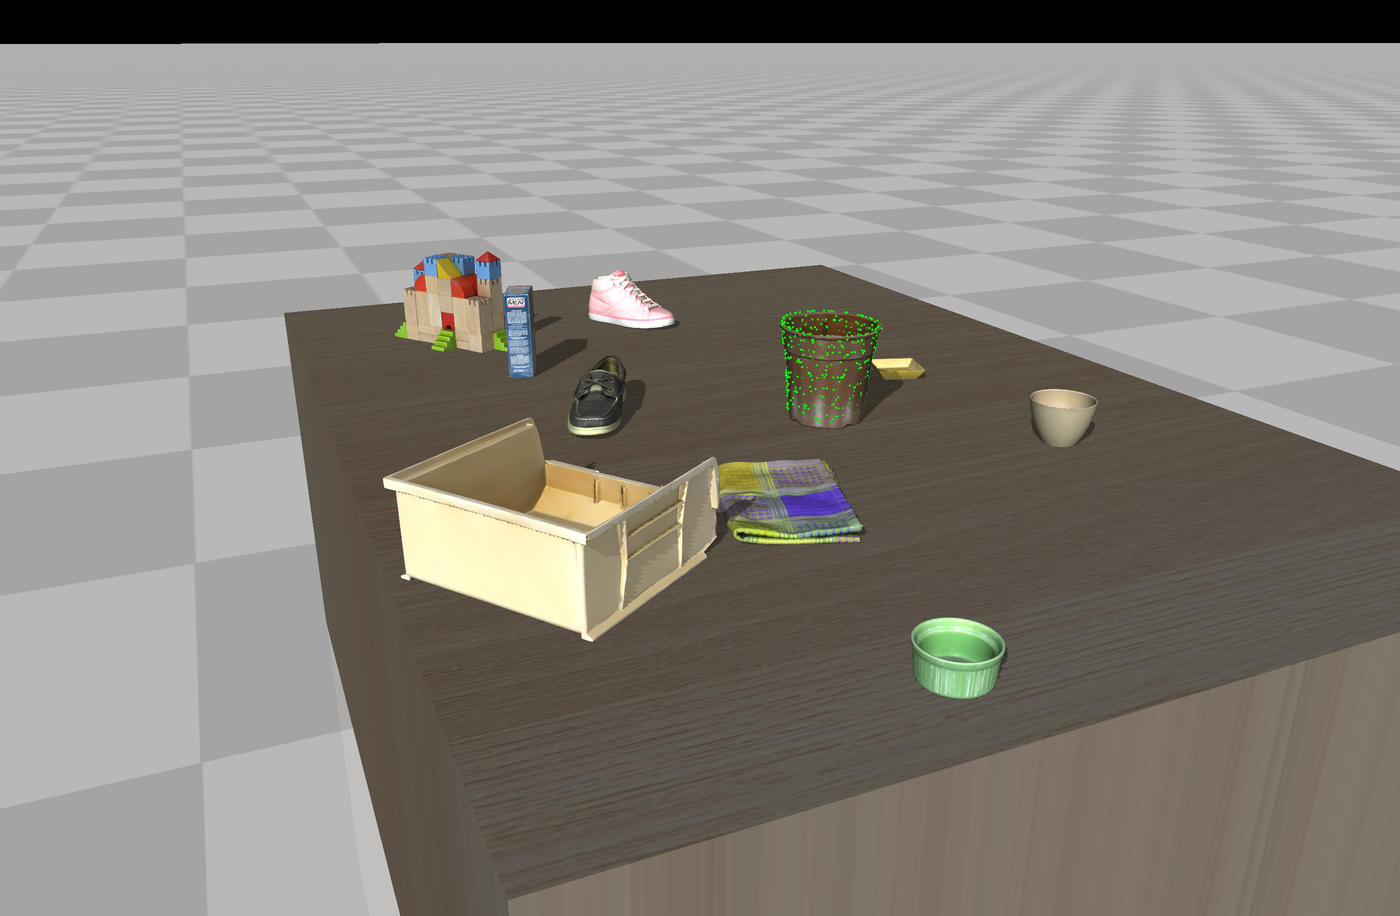

In [15]:
error = 1
for i in range(n_clusters):
    e, Tm = ICP(target_pcd_array, clustered_points[i], iteration=10, threshold=1e-5)
    if e < error:
        error = e
        best_Tm = Tm

target_pcd_array_transformed = pcd_transform(target_pcd_array, best_Tm)

env.reset()
env.init_viewer(
    azimuth           = 163.88,
    distance          = 4.5,
    elevation         = -10,
    lookat            = [0.01,0.11,0.5],
    transparent       = False,
    black_sky         = True,
    use_rgb_overlay   = True,
    loc_rgb_overlay   = 'top right',
    use_rgb_overlay_2 = False,
    loc_rgb_overlay_2 = 'bottom right',
)

for obj_idx,obj_body_name in enumerate(obj_names):
    env.set_p_base_body(body_name=obj_body_name,p=obj_xyzs[obj_idx,:])
    obj_R = obj_Rs[obj_idx,:].reshape(3,3)
    env.set_R_base_body(body_name=obj_body_name,R=obj_R)
env.forward(increase_tick=False)

while env.is_viewer_alive():
    env.step()

    # for p in whole_pcd_array[::10]: env.plot_sphere(p=p,r=0.002,rgba=[0.05,0.95,0.05,1])
    for p in target_pcd_array_transformed[::10]: env.plot_sphere(p=p,r=0.002,rgba=[0.05,0.95,0.05,1])
    env.render()

    image_backup, _ = env.grab_rgbd_img()
    if image_backup.sum() > 0: image = image_backup.copy()

env.close_viewer()

import mediapy
mediapy.show_image(image, width = 1400)